In [1]:
import numpy as np
import pandas as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow import keras
# 生成对抗式神经网络1

# class Identifier(keras.Model):
#     '''
#     识别器模型生成 
#     '''
#     def __init__(self, convolutionCount, convKernelSize, convFilterCount, poolingCount, poolingSize, dropoutSize, dropoutRate):
#         super().__init__()
        
#         self.layersCount = convolutionCount

#         #-- create the convolution layers
#         self.convolution = []
#         for i in range(convolutionCount):
#             self.convolution.append(
#                 keras.layers.Conv2D(
#                     filters = convFilterCount[i],
#                     kernel_size = convKernelSize[i]
#                 )
#             )

#         #-- create the pooling layers
#         self.pooling = []
#         for i in range(poolingCount):
#             self.pooling.append(
#                 keras.layers.MaxPool2D(
#                     pool_size = poolingSize[i]
#                 )
#             )
        
#         #-- use the dropout layers
#         self.dropout = []
#         for i in range(dropoutSize):
#             self.dropout.append(
#                 keras.layers.Dropout(dropoutRate)
#             )

#         self.outputDense = keras.layers.Dense(1, activation = 'sigmoid')
    
#     def call(self, inputDate):
#         output = self.convolution[0](inputDate)
        
#         # -- 执行前向转播
#         for i in range(1, self.layersCount):
#             output = self.convolution[i](output)
#             output = self.dropout[i](output)
#             output = self.pooling[i](output)
        
#         output = self.outputDense(output)

#         return output

def CreateGenerator(denseUnits, inputShape, imgShape):
    '''
    args:
        denseUnits: set the feature dimension of fenerator
        inputShape: help to build the model
        imgShape: tell the output shape 
    
    strides -> height * k1, weight * k2
    '''

    model = keras.Sequential([
        # keras.layers.Dense(
        #     units = denseUnits * denseUnits * 1,
        #     use_bias = False,
        #     input_shape = inputShape,
        #     activation = 'tanh'
        # ),
        
        # keras.layers.Dropout(0.3),

        keras.layers.Dense(
            units = 7 * 7 * 256,
            # imgShape * imgShape * 1,
            use_bias = False,
            input_shape = (128, )
        ),

        # keras.layers.Reshape((imgShape, imgShape, 1)),
        
        keras.layers.Reshape((7, 7, 256)),

        keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = (5, 5),
            use_bias = False,
            padding = 'same',
            strides = (1, 1)
        ),

        keras.layers.LeakyReLU(),

        keras.layers.Dropout(0.3),
        
        keras.layers.Conv2DTranspose(
            filters = 64,
            kernel_size = (5, 5),
            use_bias = False,
            padding = 'same',
            strides = (2, 2)
        ),

        keras.layers.LeakyReLU(),

        keras.layers.Dropout(0.3),

        keras.layers.Conv2DTranspose(
            filters = 1,
            kernel_size = (5, 5),
            use_bias = False,
            padding = 'same',
            strides = (2, 2),
            activation = 'tanh'
        ),
    ])
    return model

def CreateIdentifier():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (5, 5), input_shape = (28, 28, 1, )),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(32, (5, 5)),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(1)       
    ])


    return model

In [3]:
# identifierModel = Identifier(2, [(5, 5), (3, 3)], (64, 32), 2, [(2, 2), (2, 2)], 2, 0.3)
identifierModel = CreateIdentifier()
generatorModel = CreateGenerator(128, (128, ), 28)

In [4]:
import tensorflow as tf

crossLoss = keras.losses.BinaryCrossentropy(from_logits = True)
generatorOptimizer = keras.optimizers.Adam(0.03)
identifierOptimizer = keras.optimizers.Adam(0.03)

def IdentifierLoss(realImgOutput, fakeImgOutput):
    '''
    func:
        return the loss of realImg and fakeImg
    args:
        realImgOutput: the output of real input image
        fakeImgOutput: the output of fake image which generator created
    '''
    lossReal = crossLoss(tf.ones_like(realImgOutput), realImgOutput)
    lossFake = crossLoss(tf.zeros_like(fakeImgOutput), fakeImgOutput)

    return lossReal + lossFake

def GeneratorLoss(fakeImgOutput):
    return crossLoss(tf.ones_like(fakeImgOutput), fakeImgOutput)

BATCHSIZE = 64
NOISEDIM = 128 
BUFFERSIZE = 6000
EOPCHES = 5

@tf.function
def TrainOneStep(identifierModel, generatorModel, images):
    noise = tf.random.normal([BATCHSIZE, 128])
    
    with tf.GradientTape() as genTape, tf.GradientTape() as ideTape:
        generatedImages = generatorModel(noise, training = True)

        realOutput = identifierModel(images, training = True)
        fakeOutput = identifierModel(generatedImages, training = False)

        genLoss = GeneratorLoss(fakeOutput)
        ideLoss = IdentifierLoss(realOutput, fakeOutput)
    genGradients = genTape.gradient(genLoss, generatorModel.trainable_variables)
    ideGradients = ideTape.gradient(ideLoss, identifierModel.trainable_variables)
        
    generatorOptimizer.apply_gradients(zip(genGradients, generatorModel.trainable_variables))
    identifierOptimizer.apply_gradients(zip(ideGradients, identifierModel.trainable_variables))

In [5]:


(trainX, trainY), (testX, testY) = keras.datasets.mnist.load_data()

trainX = (trainX - 127.5) / 127.5                                           # map the img to [-1, 1]
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')

trainDataset = tf.data.Dataset.from_tensor_slices(trainX).shuffle(BUFFERSIZE).batch(BATCHSIZE)

In [6]:
import os 

if os.path.exists('../SavedModel/GAN/identifier.h5'):
    identifierModel.load_weights('../SavedModel/GAN/identifier.h5')
    generatorModel.load_weights('../SavedModel/GAN/generator.h5')

for i in range(EOPCHES):
    for batch in trainDataset:
        TrainOneStep(identifierModel, generatorModel, batch)
    identifierModel.save_weights('../SavedModel/GAN/identifier.h5')
    generatorModel.save_weights('../SavedModel/GAN/generator.h5')

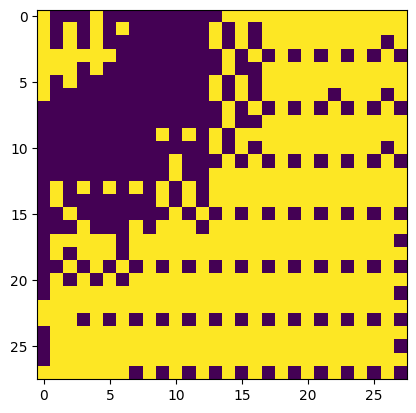

In [11]:
noise = tf.random.normal([1, 128])

output = generatorModel(noise, training = False)

plt.imshow(output[0, :, :, 0])
